# Kuzushiji Character Recognition

## Imports and Configuration
First, we need to import our libraries and set random seeds for when we do our train/test split

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
# reproducibility
np.random.seed(2021)
random.seed(2021)

## Dataset
Our dataset (Kuzishiji-49 or KMNIST) already puts our data as numpy arrays, in a compressed `npz` format.

In [3]:
# load compressed numpy arrays
dataset = "kmnist" # options are k49 or kmnist

# train images
with np.load(f'./datasets/{dataset}-train-imgs.npz') as data:
    X_tr = data['arr_0']

# train labels
with np.load(f'./datasets/{dataset}-train-labels.npz') as data:
    Y_tr = data['arr_0']
    
# validation images
with np.load(f'./datasets/{dataset}-test-imgs.npz') as data:
    X_val = data['arr_0']

# validation labels
with np.load(f'./datasets/{dataset}-test-labels.npz') as data:
    Y_val = data['arr_0']

If we take a look at our labels, we can see that they're just uints, so no need to do any conversions. We are provided with a classmap that maps numbers to unicode characters. We'll load that and make a helpful function to convert a label to a character.

In [4]:
Y_val[:10]

array([2, 9, 3, 8, 3, 3, 8, 3, 2, 5], dtype=uint8)

In [5]:
# create lookup table + conversion function to convert label to UTF-8 char
lookup_df = pd.read_csv(f'./datasets/{dataset}_classmap.csv')
lookup_df = lookup_df[['codepoint', 'char']]

def label_to_char(label):
    return lookup_df.iloc[label]['char']

In [6]:
label_to_char(Y_val[:10])

2    す
9    を
3    つ
8    れ
3    つ
3    つ
8    れ
3    つ
2    す
5    は
Name: char, dtype: object

Taking a look at the shapes of our data and the quantity of samples we have:

In [7]:
print("# of training instances:", X_tr.shape[0])
print("# of validation instances:", X_val.shape[0])
print("Total # of instances:", X_tr.shape[0] + X_val.shape[0])
print("\n")
print("Shape of training instance features:", X_tr.shape[1:])
print("Shape of validation instance features:", X_val.shape[1:])

# of training instances: 60000
# of validation instances: 10000
Total # of instances: 70000


Shape of training instance features: (28, 28)
Shape of validation instance features: (28, 28)


Instead of having features in the shape of (28, 28), let's reshape our features to (784,) so that we can easily manipulate these arrays.

In [8]:
X_tr.shape

(60000, 28, 28)

In [9]:
X_tr = X_tr.reshape((X_tr.shape[0], 28*28))
X_tr.shape

(60000, 784)

In [10]:
X_val.shape

(10000, 28, 28)

In [11]:
X_val = X_val.reshape((X_val.shape[0], 28*28))
X_val.shape

(10000, 784)

We'll also make a helper function to display a given sample

In [12]:
def display_sample(sample, shape=(28,28), figsize=(4,4)):
    reshaped = sample.reshape(shape)
    scaled = sample * 255
    plt.axis('off')
#   plt.figure(figsize=figsize)
    plt.imshow(reshaped, cmap='Greys', interpolation='nearest')

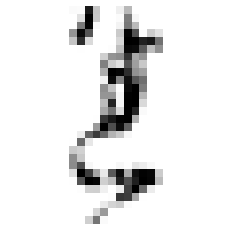

In [13]:
display_sample(X_tr[0])

## Preprocessing and Pipeline Creation

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [15]:
pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('svc', SVC())
])
pipe

Pipeline(steps=[('scalar', StandardScaler()), ('svc', SVC())])

## Fit and Predictions

In [24]:
import time

In [16]:
start = time.time()
pipe.fit(X_tr, Y_tr)
stop = time.time()
print(f"{stop-start} seconds to train")

Pipeline(steps=[('scalar', StandardScaler()), ('svc', SVC())])

In [17]:
pipe.score(X_val, Y_val)

0.8951

In [27]:
y_pred = pipe.predict(X_val)

In [28]:
print(classification_report(y_pred, Y_val, labels=[i for i in range(len(lookup_df))]))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       992
           1       0.88      0.90      0.89       980
           2       0.84      0.79      0.81      1065
           3       0.96      0.90      0.93      1069
           4       0.88      0.88      0.88       996
           5       0.85      0.97      0.91       874
           6       0.93      0.86      0.89      1082
           7       0.88      0.94      0.91       932
           8       0.93      0.88      0.90      1054
           9       0.87      0.91      0.89       956

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.89     10000



## Analysis